In [2]:
import pandas as pd
from fbprophet import Prophet

In [8]:
_df = pd.read_csv('https://www.tepco.co.jp/forecast/html/images/juyo-2017.csv', encoding="shift-jis", skiprows=1)

In [10]:
_df.head()

,DATE,TIME,実績(万kW)
0,2017/1/1,0:00,2783
1,2017/1/1,1:00,2634
2,2017/1/1,2:00,2520
3,2017/1/1,3:00,2438
4,2017/1/1,4:00,2389


In [15]:
years = [2017, 2018, 2019]

# year = years[0]
df  = pd.DataFrame()
for year in years:
  _df = pd.read_csv(f'https://www.tepco.co.jp/forecast/html/images/juyo-{year}.csv', encoding="shift-jis", skiprows=1)
  df = pd.concat([df, _df], axis = 0)

In [16]:
df.head()

,DATE,TIME,実績(万kW)
0,2017/1/1,0:00,2783
1,2017/1/1,1:00,2634
2,2017/1/1,2:00,2520
3,2017/1/1,3:00,2438
4,2017/1/1,4:00,2389


In [18]:
df.tail()

,DATE,TIME,実績(万kW)
8755,2019/12/31,19:00,3302
8756,2019/12/31,20:00,3263
8757,2019/12/31,21:00,3182
8758,2019/12/31,22:00,3077
8759,2019/12/31,23:00,3029


In [21]:
df = df.reset_index(drop=True)

In [22]:
df['DATE'][0]

'2017/1/1'

In [23]:
df['TIME'][0]

'0:00'

In [29]:
date = df['DATE'][0]
time = df['TIME'][0]
str_datetime =  f'{date} {time}'
str_datetime

'2017/1/1 0:00'

In [30]:
from datetime import datetime as dt

In [43]:
datetime = dt.strptime(str_datetime, '%Y/%m/%d %H:%M')
datetime

datetime.datetime(2019, 12, 31, 23, 0)

In [44]:
datetimes =  []

for index, datum in df.iterrows():
  date = datum['DATE']
  time = datum['TIME']
  str_datetime = f'{date} {time}'
  datetime = dt.strptime(str_datetime, '%Y/%m/%d %H:%M')
  datetimes.append(datetime)

In [47]:
datetimes[:3]

[datetime.datetime(2017, 1, 1, 0, 0),
 datetime.datetime(2017, 1, 1, 1, 0),
 datetime.datetime(2017, 1, 1, 2, 0)]

In [48]:
df['ds'] = datetimes

In [49]:
df.head()

,DATE,TIME,実績(万kW),ds
0,2017/1/1,0:00,2783,2017-01-01 00:00:00
1,2017/1/1,1:00,2634,2017-01-01 01:00:00
2,2017/1/1,2:00,2520,2017-01-01 02:00:00
3,2017/1/1,3:00,2438,2017-01-01 03:00:00
4,2017/1/1,4:00,2389,2017-01-01 04:00:00


In [51]:
df = df.rename(columns={'実績(万kW)':'y'})

# モデル構築

In [55]:
model = Prophet()

In [56]:
model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [61]:
# 2020年はうるう年ありなので366日
future = model.make_future_dataframe(24*366, freq = 'H')

In [62]:
future.tail()

,ds
35059,2020-12-31 19:00:00
35060,2020-12-31 20:00:00
35061,2020-12-31 21:00:00
35062,2020-12-31 22:00:00
35063,2020-12-31 23:00:00


In [64]:
forecast = model.predict(future)

# 評価

In [66]:
import matplotlib.pyplot as plt

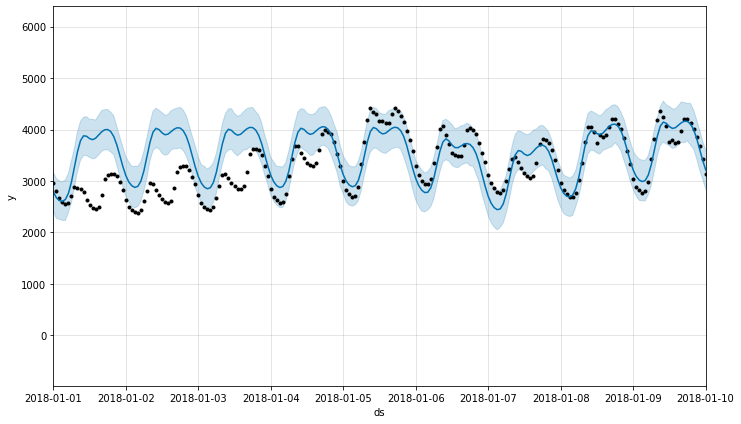

In [71]:
model.plot(forecast)
plt.xlim(dt(2018,1,1), dt(2018,1,10))
plt.show()

In [92]:
df_2020 =  pd.read_csv(f'https://www.tepco.co.jp/forecast/html/images/juyo-2020.csv', encoding="shift-jis", skiprows=1)

In [93]:
df_2020.head()

,DATE,TIME,実績(万kW)
0,2020/1/1,0:00,2857
1,2020/1/1,1:00,2703
2,2020/1/1,2:00,2602
3,2020/1/1,3:00,2520
4,2020/1/1,4:00,2464


In [94]:
forecast_2020 = forecast[forecast['ds'] >= dt(2020,1,1)].reset_index(drop = True)

In [95]:
forecast_2020.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01 00:00:00,3134.340011,2501.283426,3313.395250,3134.340011,3134.340011,-224.856836,-224.856836,-224.856836,-488.417802,-488.417802,-488.417802,108.739814,108.739814,108.739814,154.821152,154.821152,154.821152,0.0,0.0,0.0,2909.483175
1,2020-01-01 01:00:00,3134.297635,2407.590326,3154.830146,3134.297635,3134.297635,-354.546087,-354.546087,-354.546087,-617.309962,-617.309962,-617.309962,108.086395,108.086395,108.086395,154.677480,154.677480,154.677480,0.0,0.0,0.0,2779.751548
2,2020-01-01 02:00:00,3134.255259,2310.036187,3113.911187,3134.255259,3134.255259,-432.164816,-432.164816,-432.164816,-694.375983,-694.375983,-694.375983,107.671307,107.671307,107.671307,154.539860,154.539860,154.539860,0.0,0.0,0.0,2702.090443
3,2020-01-01 03:00:00,3134.212883,2288.730008,3063.533847,3134.212883,3134.212883,-466.064530,-466.064530,-466.064530,-727.960893,-727.960893,-727.960893,107.488055,107.488055,107.488055,154.408308,154.408308,154.408308,0.0,0.0,0.0,2668.148353
4,2020-01-01 04:00:00,3134.170507,2274.179057,3057.162250,3134.170507,3134.170507,-446.333967,-446.333967,-446.333967,-708.142983,-708.142983,-708.142983,107.526173,107.526173,107.526173,154.282843,154.282843,154.282843,0.0,0.0,0.0,2687.836539


In [96]:
df_2020 = df_2020.rename(columns={'実績(万kW)':'y'})
df_2020.head()

,DATE,TIME,y
0,2020/1/1,0:00,2857
1,2020/1/1,1:00,2703
2,2020/1/1,2:00,2602
3,2020/1/1,3:00,2520
4,2020/1/1,4:00,2464


In [97]:
# yhat:予測値
forecast_2020['yhat']

0       2909.483175
1       2779.751548
2       2702.090443
3       2668.148353
4       2687.836539
           ...     
8779    3432.955979
8780    3329.200745
8781    3163.596655
8782    2952.388022
8783    2734.208687
Name: yhat, Length: 8784, dtype: float64

In [98]:
results = pd.DataFrame()

In [100]:
# 実測値
results['t'] =  df_2020['y']
# 予測値
results['y'] =  forecast_2020['yhat']
results['diff'] = results['t'] - results['y']

results.head()

,t,y,diff
0,2857,2370.686945,486.313055
1,2703,2232.501548,470.498452
2,2602,2147.420398,454.579602
3,2520,2107.160716,412.839284
4,2464,2121.697412,342.302588


In [101]:
# MAP：平均絶対誤差率

# MSE(Mean Squared Error)：平均二乗誤差
# RMSE(Root Mean Squared Error)：平均平方二乗誤差

In [102]:
import numpy as np

In [104]:
np.mean(abs((results['y'] - results['t'])/results['y'])*100)

11.322086694572873

# 精度向上のための施策

In [128]:
df_holidays = pd.read_csv('holidays+hotdays+hour_2017_2019.csv')
df_holidays.head()

,ds,holiday,lower_window,upper_window
0,2017/01/01 0:00:00,holiday,0,1
1,2017/01/01 1:00:00,holiday,0,1
2,2017/01/01 10:00:00,holiday,0,1
3,2017/01/01 11:00:00,holiday,0,1
4,2017/01/01 12:00:00,holiday,0,1


In [129]:
df.y.max()

5653

In [130]:
# 上限値をcapに設定
df['cap'] = 5700
df.head()

,DATE,TIME,y,ds,cap
0,2017/1/1,0:00,2783,2017-01-01 00:00:00,5700
1,2017/1/1,1:00,2634,2017-01-01 01:00:00,5700
2,2017/1/1,2:00,2520,2017-01-01 02:00:00,5700
3,2017/1/1,3:00,2438,2017-01-01 03:00:00,5700
4,2017/1/1,4:00,2389,2017-01-01 04:00:00,5700


In [134]:
model = Prophet(
    growth = 'logistic',
    yearly_seasonality = True,
    weekly_seasonality = True,
    daily_seasonality = True,
    holidays = df_holidays
)

In [135]:
df.head()

,DATE,TIME,y,ds,cap
0,2017/1/1,0:00,2783,2017-01-01 00:00:00,5700
1,2017/1/1,1:00,2634,2017-01-01 01:00:00,5700
2,2017/1/1,2:00,2520,2017-01-01 02:00:00,5700
3,2017/1/1,3:00,2438,2017-01-01 03:00:00,5700
4,2017/1/1,4:00,2389,2017-01-01 04:00:00,5700


In [136]:
model.fit(df)

In [138]:
future['cap'] = 5700
future.head()

,ds,cap
0,2017-01-01 00:00:00,5700
1,2017-01-01 01:00:00,5700
2,2017-01-01 02:00:00,5700
3,2017-01-01 03:00:00,5700
4,2017-01-01 04:00:00,5700


In [139]:
forecast = model.predict(future)

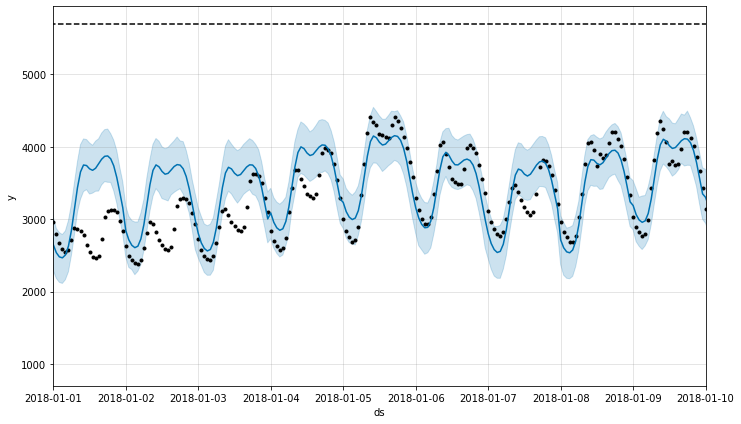

In [140]:
model.plot(forecast)

plt.xlim(dt(2018,1,1), dt(2018,1,10))
plt.show()

In [141]:
forecast_2020 = forecast[forecast['ds'] >= dt(2020,1,1)].reset_index(drop = True)

In [144]:
# 実測値
results['t'] =  df_2020['y']
# 予測値
results['y'] =  forecast_2020['yhat']
results['diff'] = results['t'] - results['y']

results.head()

,t,y,diff
0,2857,2995.530920,-138.530920
1,2703,2865.511587,-162.511587
2,2602,2787.601346,-185.601346
3,2520,2753.448512,-233.448512
4,2464,2772.966300,-308.966300


In [145]:
np.mean(abs((results['y'] - results['t'])/results['y'])*100)

8.539586077524302

# 周期性の確認

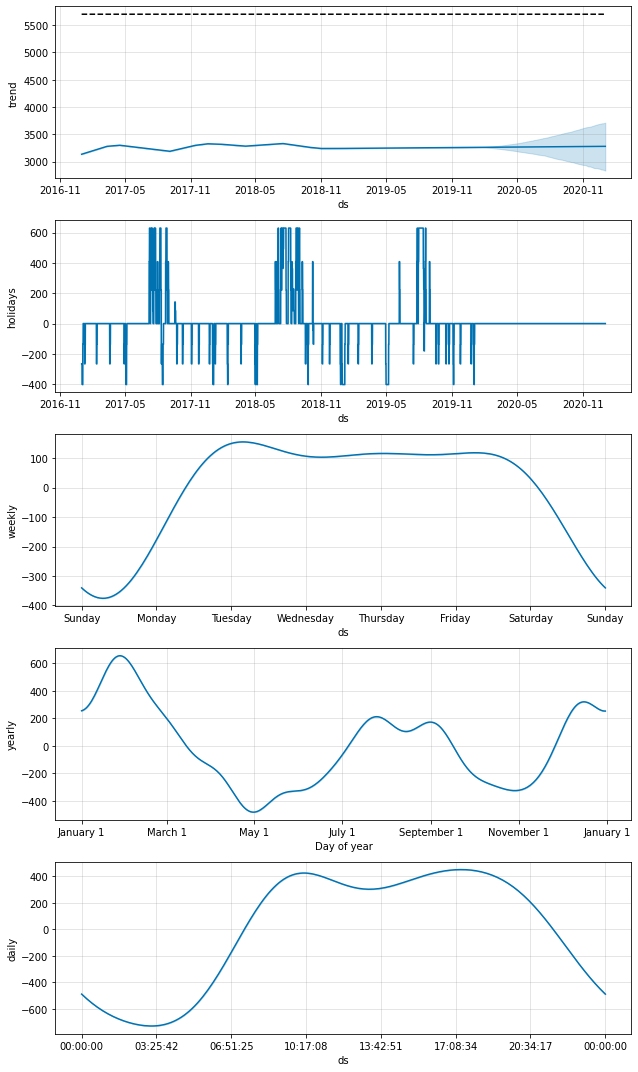

In [146]:
model.plot_components(forecast)
plt.show()